# Fitting the Barnes Gyro relation using latent parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import warnings
warnings.filterwarnings('ignore')

For now we'll assume that BPRP and Age have no uncertainty. We'll add the uncertainty on those later with a latent implementation.

$P = \tau^d \times a(B - V - c)^b$

where $P$ is rotation in days
$\tau$ is age (in Myr),
B-V are colour in magnitude,
the rest are free parameters


In [2]:
angus = [0.40, 0.31, 0.45, 0.55] 

def gyro(tau, bv, a, b, c, d):
    return tau*1000**d * a*(bv - c)**b

In [4]:
np.random.seed(12)
npts = 25

bprp_true = np.linspace(0.5, 1.5, npts)
age_true = np.linspace(2, 8, npts)
period_true = gyro(age_true, bprp_true, *angus)

sigma_p = 3.*np.ones(npts)
period_obs = period_true + np.random.randn(npts) * sigma_p

sigma_bprp = .05 * np.ones(npts)
bprp_obs = bprp_true + np.random.randn(npts) * sigma_bprp

sigma_age = np.random.uniform(.05, .1) * age_true
age_obs = age_true + np.random.randn(npts) * sigma_age

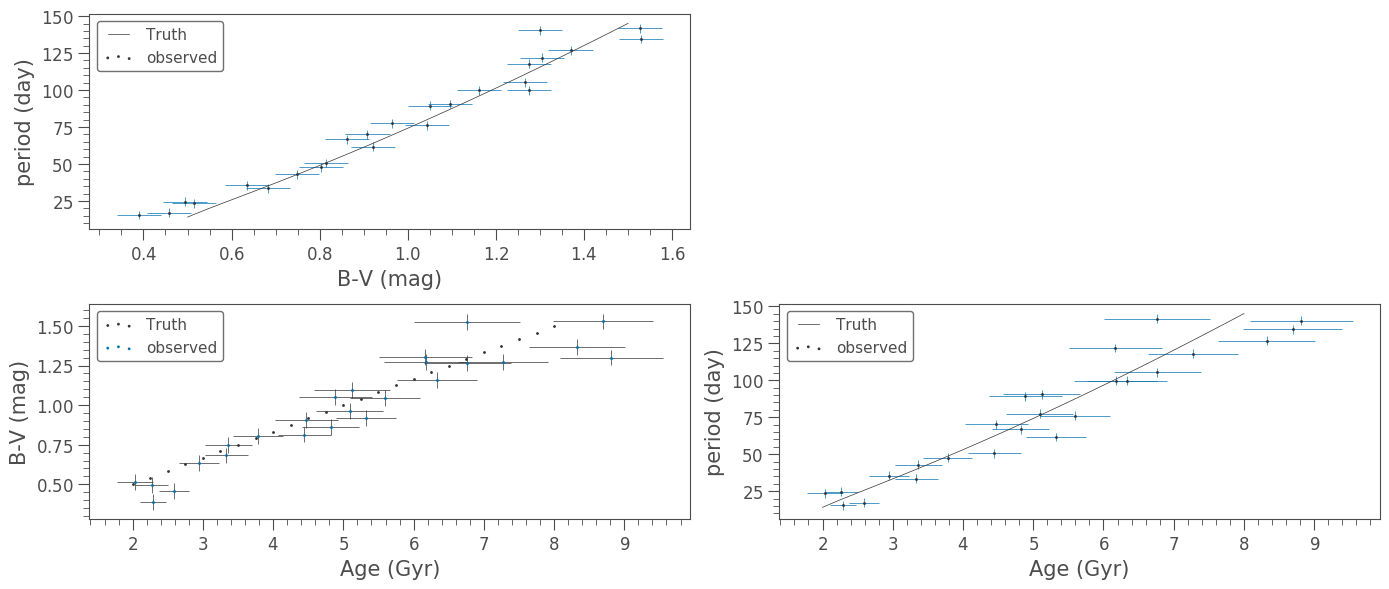

In [5]:
import matplotlib.gridspec as gridspec
import mystyle as ms

with plt.style.context(ms.ms):
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(2, 2)
    ax0 = plt.subplot(gs[0,:1])
    ax0.plot(bprp_true, period_true, label='Truth')
    ax0.scatter(bprp_obs, period_obs,zorder=1, label='observed')
    ax0.errorbar(bprp_obs, period_obs, yerr=sigma_p, xerr=sigma_bprp, fmt='|',zorder=0)
    ax0.set_xlabel('B-V (mag)')
    ax0.set_ylabel('period (day)')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1,1])
    ax1.plot(age_true, period_true, label='Truth')
    ax1.scatter(age_obs, period_obs,zorder=1, label='observed')
    ax1.errorbar(age_obs, period_obs, yerr=sigma_p, xerr=sigma_age, fmt='|',zorder=0)
    ax1.set_xlabel('Age (Gyr)')
    ax1.set_ylabel('period (day)')
    ax1.legend()    
    
    ax2 = plt.subplot(gs[1,0])
    ax2.scatter(age_true, bprp_true, label='Truth')
    ax2.scatter(age_obs, bprp_obs,zorder=1, label='observed')
    ax2.errorbar(age_obs, bprp_obs, yerr=sigma_bprp, xerr=sigma_age, fmt='|',zorder=0)
    ax2.set_xlabel('Age (Gyr)')
    ax2.set_ylabel('B-V (mag)')
    ax2.legend()    
    
    fig.tight_layout()
    plt.show()

Now lets fit for Period using a latent parameter model

In [18]:
latentfit = '''
data {
    int<lower=1> N;
    real<lower=0> P[N];
    real<lower=0> sigma_p[N];
    
    real bprp[N];
    real<lower=0> sigma_bprp[N];
    
    real<lower=0> age[N];
    real<lower=0> sigma_age[N];
}
parameters {
    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> c;
    real<lower=0> d;
    
    real<lower=0> age_true[N];
    real bprp_true[N];
}
transformed parameters{
    real<lower=0> P_true[N];
    
    for (n in 1:N){
        P_true[n] = (age_true[n]*1000)^d * a * (bprp[n] - c)^b;
    }
}
model {
    a ~ normal(0., 1.);
    b ~ normal(0., 1.);
    c ~ normal(0., 1.);
    d ~ normal(0., 1.);
    
    age ~ normal(age_true, sigma_age);
    bprp ~ normal(bprp_true, sigma_bprp);
    P ~ normal(P_true, sigma_p);
}

'''
sm = pystan.StanModel(model_code = latentfit, model_name='latentfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL latentfit_3b149ed0fe06845b36f8b67deb554182 NOW.


In [19]:
data = {'N' : len(period_obs),
       'P' : period_obs,
       'sigma_p' : sigma_p,
       'bprp' : bprp_obs,
       'sigma_bprp' : sigma_bprp,
       'age' : age_obs,
       'sigma_age' : sigma_age}


init = {'a' : angus[0],
        'b' : angus[1],
        'c' : angus[2],
        'd' : angus[3],
        'age_true' : age_true,
        'bprp_true' : bprp_true}

In [21]:
period_obs

array([ 15.53687658,  17.12157107,  24.64565702,  23.52206709,
        35.62332749,  33.56558384,  43.07157399,  47.6688173 ,
        50.67101017,  66.85922973,  61.69057864,  70.22865526,
        77.51153923,  76.0737422 ,  89.32307755,  90.58549872,
        99.7226519 ,  99.75197047, 105.28694177, 117.95859966,
       121.8585457 , 126.86161839, 134.52641168, 140.41060703,
       141.65404272])

In [20]:
fit = sm.sampling(data=data, iter=5000, chains=4, seed=11,
                  init = [init for n in range(4)])

RuntimeError: Initialization failed.

In [ ]:
print(fit)

In [ ]:
fit.plot()
plt.show()

In [ ]:
import corner
labels=['a','b','c','d']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, truths=angus,
              quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

In [ ]:
from pymc3.gp.util import plot_gp_dist

with plt.style.context(ms.ms):
    fig = plt.figure()
    ax = fig.gca()
        
    ax.plot(bprp_true, period_true, "dodgerblue", lw=3, label="True period");
    ax.errorbar(np.median(fit['bprp_true'],axis=0), np.median(fit['P_true'],axis=0),
               xerr=np.std(fit['bprp_true'],axis=0), yerr=np.std(fit['P_true'],axis=0),
               fmt='o', c='k', label="Latents");

    ax.errorbar(bprp_true, period_obs, yerr=sigma_p, xerr=sigma_bprp,
                fmt='o', ms=3, alpha=0.5, label="Observed data");
    
    ax.set_xlabel('B-V (mag)')
    ax.set_ylabel('period (day)')
    ax.legend()
    plt.show();
    
    ###########
    
    fig = plt.figure()
    ax = fig.gca()
        
    ax.plot(age_true, period_true, "dodgerblue", lw=3, label="True period");
    ax.errorbar(np.median(fit['age_true'],axis=0), np.median(fit['P_true'],axis=0),
                xerr=np.std(fit['age_true'],axis=0), yerr=np.std(fit['P_true'],axis=0),
               fmt='o', c='k', label="Latents");
    ax.errorbar(age_true, period_obs, yerr=sigma_p, xerr=sigma_age, 
                fmt='o', ms=3, alpha=0.5, label="Observed data");
        
    ax.set_xlabel('Age (gyr)')
    ax.set_ylabel('period (day)')
    ax.legend()
    plt.show(); 

In [ ]:
fig = plt.figure()
ax = fig.gca()
    
gyrores = [np.median(fit[label]) for label in ['a','b','c','d']]
Ppred = gyro(age_obs, bprp_obs, *gyrores)

ax.scatter(bprp_obs, period_obs - Ppred)